In [5]:
import numpy as np
import pandas as pd

import neurodsp
from bycycle.features import compute_features
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Compute cycle-by-cycle features

In [2]:
# Load data
ca1_raw = np.load('data/ca1.npy')
ec3_raw = np.load('data/ec3.npy')
Fs = 1250
f_theta = (4, 10)

# Apply broad bandpass filter
f_bandpass = (1, 25)
filter_seconds = (2, .5)
ca1 = neurodsp.filter(ca1_raw, Fs, 'highpass', f_bandpass[0],
                      N_seconds=filter_seconds[0],
                      remove_edge_artifacts=False)
ca1 = neurodsp.filter(ca1, Fs, 'lowpass', f_bandpass[1],
                      N_seconds=filter_seconds[1],
                      remove_edge_artifacts=False)
ec3 = neurodsp.filter(ec3_raw, Fs, 'highpass', f_bandpass[0],
                      N_seconds=filter_seconds[0],
                      remove_edge_artifacts=False)
ec3 = neurodsp.filter(ec3, Fs, 'lowpass', f_bandpass[1],
                      N_seconds=filter_seconds[1],
                      remove_edge_artifacts=False)

Transition bandwidth is 0.0 Hz. Pass/stop bandwidth is 624.0 Hz
Transition bandwidth is 2.4 Hz. Pass/stop bandwidth is 25 Hz
Transition bandwidth is 0.0 Hz. Pass/stop bandwidth is 624.0 Hz
Transition bandwidth is 2.4 Hz. Pass/stop bandwidth is 25 Hz


In [ ]:
# Set parameters for defining oscillatory bursts
osc_kwargs = {'amplitude_fraction_threshold':0,
              'amplitude_consistency_threshold':.6,
              'period_consistency_threshold':.75,
              'monotonicity_threshold':.8,
              'N_cycles_min':3}

# Cycle-by-cycle analysis
df_ca1 = compute_features(ca1, Fs, f_theta, center_extrema='T',
                             burst_detection_kwargs=osc_kwargs)

df_ec3 = compute_features(ec3, Fs, f_theta, center_extrema='T',
                             burst_detection_kwargs=osc_kwargs)

# Limit analysis only to oscillatory bursts
df_ca1_cycles = df_ca1[df_ca1['is_burst']]
df_ec3_cycles = df_ec3[df_ec3['is_burst']]

# A-B. Time series of EC3 and CA1

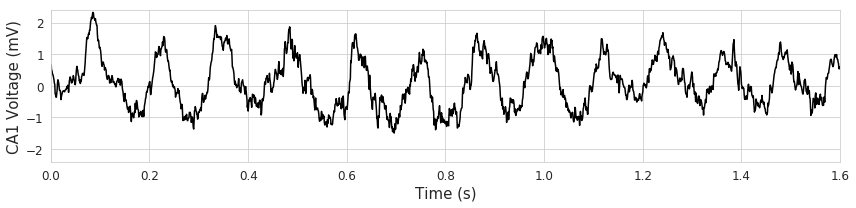

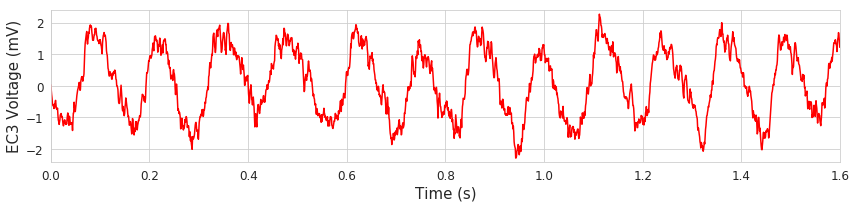

In [8]:
samplims = (10000, 12000)
ca1_plt = ca1_raw[samplims[0]:samplims[1]]/1000
ec3_plt = ec3_raw[samplims[0]:samplims[1]]/1000
t = np.arange(0, len(ca1_plt)/Fs, 1/Fs)

plt.figure(figsize=(12,3))
plt.plot(t, ca1_plt, 'k')
plt.xlim((0,1.6))
plt.ylim((-2.4,2.4))
plt.xlabel('Time (s)', size=15)
plt.ylabel('CA1 Voltage (mV)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('figs/2A_CA1_time_series.png')

plt.figure(figsize=(12,3))
plt.plot(t, ec3_plt, 'r')
plt.xlim((0,1.6))
plt.ylim((-2.4,2.4))
plt.xlabel('Time (s)', size=15)
plt.ylabel('EC3 Voltage (mV)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('figs/2B_EC3_time_series.png')

# C-F. Feature distributions comparing CA1 and EC3

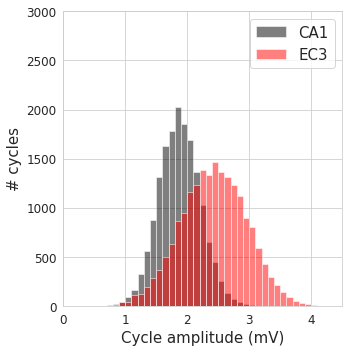

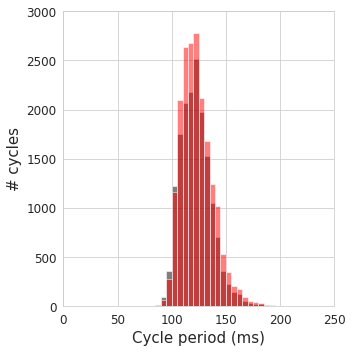

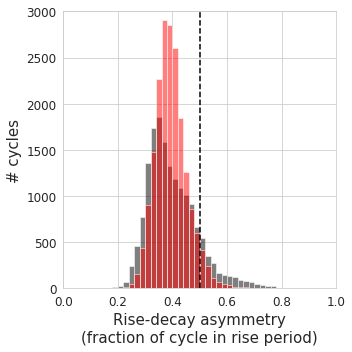

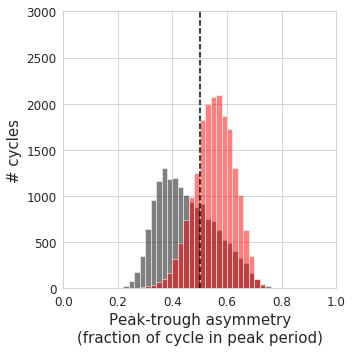

In [9]:
ylim = 3000

plt.figure(figsize=(5,5))
plt.hist(df_ca1_cycles['volt_amp']/1000, bins=np.arange(0, 8, .1), color='k', alpha=.5, label='CA1')
plt.hist(df_ec3_cycles['volt_amp']/1000, bins=np.arange(0, 8, .1), color='r', alpha=.5, label='EC3')
plt.xticks(np.arange(5), size=12)
plt.legend(fontsize=15)
plt.yticks(size=12)
plt.xlim((0,4.5))
plt.ylim((0,ylim))
plt.xlabel('Cycle amplitude (mV)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
plt.savefig('figs/2C_dist_amp.png')

plt.figure(figsize=(5,5))
plt.hist(df_ca1_cycles['period'] / Fs * 1000, bins=np.arange(0, 250, 5), color='k', alpha=.5)
plt.hist(df_ec3_cycles['period'] / Fs * 1000, bins=np.arange(0, 250, 5), color='r', alpha=.5)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim((0,250))
plt.ylim((0,ylim))
plt.xlabel('Cycle period (ms)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
plt.savefig('figs/2D_dist_period.png')

plt.figure(figsize=(5,5))
plt.hist(df_ca1_cycles['time_rdsym'], bins=np.arange(0, 1, .02), color='k', alpha=.5)
plt.hist(df_ec3_cycles['time_rdsym'], bins=np.arange(0, 1, .02), color='r', alpha=.5)
plt.plot([.5, .5], [0, ylim], 'k--')
plt.ylim((0,ylim))
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim((0,1))
plt.xlabel('Rise-decay asymmetry\n(fraction of cycle in rise period)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
plt.savefig('figs/2E_dist_rdsym.png')

plt.figure(figsize=(5,5))
plt.hist(df_ca1_cycles['time_ptsym'], bins=np.arange(0, 1, .02), color='k', alpha=.5)
plt.hist(df_ec3_cycles['time_ptsym'], bins=np.arange(0, 1, .02), color='r', alpha=.5)
plt.plot([.5, .5], [0, ylim], 'k--')
plt.ylim((0,ylim))
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim((0,1))
plt.xlabel('Peak-trough asymmetry\n(fraction of cycle in peak period)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
plt.savefig('figs/2F_dist_ptsym.png')

### Cycle feature correlations

In [10]:
print('rdsym-amp', stats.spearmanr(df_ca1_cycles['time_rdsym'], df_ca1_cycles['volt_amp']))
print('rdsym-period', stats.spearmanr(df_ca1_cycles['time_rdsym'], df_ca1_cycles['period']))
print('rdsym-ptsym', stats.spearmanr(df_ca1_cycles['time_rdsym'], df_ca1_cycles['time_ptsym']))

rdsym-amp SpearmanrResult(correlation=0.00022201571372647085, pvalue=0.9773249547833809)
rdsym-period SpearmanrResult(correlation=0.18030003159176386, pvalue=8.275432552326885e-120)
rdsym-ptsym SpearmanrResult(correlation=-0.06983353848893371, pvalue=3.51887884306604e-19)
